# **Unsupervised DEM Segmentation**

In [0]:
#import libraries
from skimage.feature import canny 
import scipy.ndimage as ndimage
import cv2
import gdal
import numpy as np
from skimage.morphology import skeletonize
from skimage import measure

In [0]:
def segmentDEM(original_dem):
	height,width = original_dem.shape
	fg = original_dem>0


	blurred_f = ndimage.gaussian_filter(original_dem, 6)
	filter_blurred_f = ndimage.gaussian_filter(blurred_f, 1)
	alpha = 20
	x = alpha * (blurred_f - filter_blurred_f)
	blurred_f=filter_blurred_f=None
	sharpened = original_dem + x

	one=cv2.bilateralFilter(sharpened,5,5,5)
	sharpened=None
	cannyEdge = canny(one, sigma=0.15, low_threshold=0.15, high_threshold=1, mask=fg>0)
	one=None
	cannyEdge = cannyEdge>0
	cannyEdge = cannyEdge.astype(np.uint8)*255

	kernel = np.ones((10,10),np.uint8)
	mask2 = cv2.dilate(cannyEdge,kernel,iterations = 1)
	cannyEdge=None
	mask2=mask2>0
	mask2=mask2.astype(np.uint8)
	fg=fg.astype(np.uint8)

	pad = np.ones((height+2,width+2),dtype=np.uint8)
	pad[1:height+1,1:width+1]=mask2
	mask2 = pad
	pad = None 	

	skeleton = 1-skeletonize(mask2)
	mask2=None
	
	index,n = measure.label(skeleton, connectivity=1, return_num=True)
	skeleton=None
	index = index[1:height+1,1:width+1]
	if height*width!=np.sum(fg):
		kernel = np.ones((15,15),np.uint8)
		fg = cv2.erode(fg,kernel,iterations = 1)
		index = np.multiply(index,fg)
	return index,n

In [0]:
#load DEM
original_dem = gdal.Open('DEM.tif')
xmax=original_dem.RasterXSize
ymax=original_dem.RasterYSize
gtDem = original_dem.GetGeoTransform()
wkt = original_dem.GetProjection()
img1_dem = original_dem.GetRasterBand(1).ReadAsArray()
out,n=segmentDEM(img1_dem)

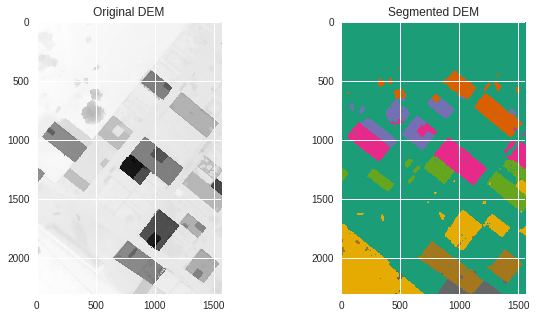

In [0]:
#plot results
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5));
ax[0].imshow(img1_dem);
ax[0].set_title('Original DEM');
ax[1].imshow(out,cmap=plt.cm.get_cmap('Dark2'));
ax[1].set_title('Segmented DEM');